In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Set, Tuple
import random

@dataclass
class SimParams:
    # Base mutation rate per base pair per year
    u: float = 1.25e-8
    
    # Number of driver positions in each gene
    n_APC: int = 604    # Number of APC driver positions
    n_TP53: int = 73    # Number of TP53 driver positions
    n_KRAS: int = 20    # Number of KRAS driver positions
    
    # Derived mutation rates per year
    r_APC: float = 604 * 1.25e-8    # APC mutation rate
    r_TP53: float = 73 * 1.25e-8    # TP53 mutation rate
    r_KRAS: float = 20 * 1.25e-8    # KRAS mutation rate
    r_LOH: float = 1.36e-4          # Rate of loss of heterozygosity
    
    # Division rates per year  
    b_APC: float = 0.2     # Division rate for APC-/- crypts
    b_KRAS: float = 0.07   # Division rate for KRAS+ crypts
    b_BOTH: float = 0.27   # Division rate for APC-/-,KRAS+ crypts (b_APC + b_KRAS)
    
    # Time parameters
    dt: float = 0.01      # Time step size (tau)
    t_max: float = 80.0   # Maximum simulation time
    
    # Initial conditions
    N_crypts: int = 10**8  # Number of initial crypts

class State:
    """Represents the genetic state of a crypt"""
    def __init__(self, APC: int, TP53: int, KRAS: int):
        # APC states:
        # 0: Wild type
        # 1: First hit LOH
        # 2: First hit mutation
        # 3: Second hit after LOH or mutation
        # 4: Double mutation
        self.APC = APC   
        
        # TP53 states: similar to APC
        self.TP53 = TP53 
        
        # KRAS states:
        # 0: Wild type
        # 1: Activated
        self.KRAS = KRAS
        
    def __hash__(self):
        return hash((self.APC, self.TP53, self.KRAS))
    
    def __eq__(self, other):
        return (self.APC, self.TP53, self.KRAS) == (other.APC, other.TP53, other.KRAS)
    
    def is_malignant(self):
        """Check if state represents a malignant crypt"""
        # Malignant states: (3,3,1), (3,4,1), (4,3,1), (4,4,1)
        return ((self.APC >= 3) and (self.TP53 >= 3) and (self.KRAS == 1))

def get_transition_rate(source: State, target: State, params: SimParams) -> float:
    """Calculate transition rate between states based on Supplementary Materials"""
    # APC transitions
    if target.APC > source.APC:
        if source.APC == 0:
            # First hit can be LOH or mutation
            return params.r_LOH if target.APC == 1 else params.r_APC
        elif source.APC == 1:
            # After LOH, only mutation possible
            return params.r_APC / 2
        elif source.APC == 2:
            # After mutation, both LOH and mutation possible
            return params.r_LOH / 2 if target.APC == 3 else params.r_APC / 2
            
    # TP53 transitions (similar to APC)
    if target.TP53 > source.TP53:
        if source.TP53 == 0:
            return params.r_LOH if target.TP53 == 1 else params.r_TP53
        elif source.TP53 == 1:
            return params.r_TP53 / 2
        elif source.TP53 == 2:
            return params.r_LOH / 2 if target.TP53 == 3 else params.r_TP53 / 2
            
    # KRAS activation
    if target.KRAS > source.KRAS:
        return params.r_KRAS
        
    return 0.0

def get_division_rate(state: State, params: SimParams) -> float:
    """Get division rate for a given state based on Supplementary Materials"""
    if state.APC >= 3:  # APC-/-
        if state.KRAS == 1:  # Also KRAS+
            return params.b_BOTH
        return params.b_APC
    elif state.KRAS == 1:  # Only KRAS+
        return params.b_KRAS
    return 0.0

def get_neighbors(state: State) -> Set[State]:
    """Get all possible next states from current state"""
    neighbors = set()
    
    # APC transitions
    if state.APC == 0:
        neighbors.add(State(1, state.TP53, state.KRAS))  # LOH
        neighbors.add(State(2, state.TP53, state.KRAS))  # Mutation
    elif state.APC == 1:
        neighbors.add(State(3, state.TP53, state.KRAS))  # Mutation after LOH
    elif state.APC == 2:
        neighbors.add(State(3, state.TP53, state.KRAS))  # LOH after mutation
        neighbors.add(State(4, state.TP53, state.KRAS))  # Second mutation
        
    # TP53 transitions
    if state.TP53 == 0:
        neighbors.add(State(state.APC, 1, state.KRAS))  # LOH
        neighbors.add(State(state.APC, 2, state.KRAS))  # Mutation
    elif state.TP53 == 1:
        neighbors.add(State(state.APC, 3, state.KRAS))  # Mutation after LOH
    elif state.TP53 == 2:
        neighbors.add(State(state.APC, 3, state.KRAS))  # LOH after mutation
        neighbors.add(State(state.APC, 4, state.KRAS))  # Second mutation
        
    # KRAS activation
    if state.KRAS == 0:
        neighbors.add(State(state.APC, state.TP53, 1))
        
    return neighbors

def tau_leaping_simulation(params: SimParams, n_runs: int = 1000) -> np.ndarray:
    """Run multiple tau-leaping simulations following supplementary materials"""
    time_points = np.arange(0, params.t_max + params.dt, params.dt)
    malignant_counts = np.zeros(len(time_points))
    
    for run in range(n_runs):
        if run % 100 == 0:
            print(f"Run {run}/{n_runs}")
            
        # Initialize population dictionary
        population = {State(0,0,0): params.N_crypts}
        had_malignant = False
        
        for t_idx, t in enumerate(time_points):
            if had_malignant:
                malignant_counts[t_idx:] += 1
                break
                
            # Process each populated state
            new_events = {}
            for state, count in list(population.items()):
                if count == 0:
                    continue
                    
                # Check for division events (negative binomial distribution)
                division_rate = get_division_rate(state, params)
                if division_rate > 0:
                    p = np.exp(-division_rate * params.dt)
                    n_divisions = np.random.negative_binomial(count, p)
                    if n_divisions > 0:
                        new_events[state] = new_events.get(state, 0) + n_divisions
                
                # Check for transitions to neighbor states
                for neighbor in get_neighbors(state):
                    rate = get_transition_rate(state, neighbor, params)
                    if rate > 0:
                        # Use Poisson approximation for small rates
                        if rate * params.dt < 0.01:
                            n_transitions = np.random.poisson(rate * params.dt * count)
                        else:
                            # Use binomial for larger rates
                            p = 1 - np.exp(-rate * params.dt)
                            n_transitions = np.random.binomial(count, p)
                            
                        if n_transitions > 0:
                            new_events[state] = new_events.get(state, 0) - n_transitions
                            new_events[neighbor] = new_events.get(neighbor, 0) + n_transitions
                            
                            if neighbor.is_malignant():
                                had_malignant = True
                                break
            
            # Update population
            for state, delta in new_events.items():
                population[state] = population.get(state, 0) + delta
                if population[state] < 0:  # Sanity check
                    population[state] = 0
                    
            if had_malignant:
                malignant_counts[t_idx:] += 1
                break
    
    return malignant_counts / n_runs

def plot_results(time_points: np.ndarray, probabilities: np.ndarray):
    """Plot the probability of malignancy over time"""
    plt.figure(figsize=(10, 6))
    plt.semilogy(time_points, probabilities, 'b-', label='Tau-leaping simulation')
    plt.xlabel('Age (years)')
    plt.ylabel('Probability of malignancy')
    plt.title('Probability of Colorectal Cancer Development')
    plt.grid(True)
    plt.legend()
    plt.show()

# Run simulation
#if __name__ == "__main__":
#    params = SimParams()
#    time_points = np.arange(0, params.t_max + params.dt, params.dt)
#    probabilities = tau_leaping_simulation(params, n_runs=10000)
#    plot_results(time_points, probabilities)

# params = SimParams(
#     dt = 0.1,           # 5-year time steps
#     t_max = 80.0,       # Full lifetime
#     N_crypts = 10**8    # Optionally reduce initial crypts
# )

# # Run with fewer simulations
# time_points = np.arange(0, params.t_max + params.dt, params.dt)
# probabilities = tau_leaping_simulation(params, n_runs=8000000)
# plot_results(time_points, probabilities)

In [4]:
from multiprocessing import Pool, cpu_count

def parallel_simulation(task_params):
    """
    Wrapper for tau-leaping simulation to run in parallel.
    """
    params, n_runs = task_params
    return tau_leaping_simulation(params, n_runs)

def run_parallel_simulations(params: SimParams, n_runs: int, n_processes: int = None):
    """
    Split simulation into multiple processes to utilize multi-core CPU.
    """
    if n_processes is None:
        n_processes = cpu_count()  # Use all available CPU cores by default
    
    # Divide the total runs among processes
    runs_per_process = n_runs // n_processes
    task_params = [(params, runs_per_process) for _ in range(n_processes)]
    
    print(f"Running {n_runs} simulations across {n_processes} processes...")
    
    with Pool(n_processes) as pool:
        results = pool.map(parallel_simulation, task_params)
    
    # Combine results from all processes
    combined_probabilities = np.sum(results, axis=0) / n_processes
    return combined_probabilities


In [4]:
# 保留您的原始参数
params = SimParams(
    dt=0.1,  # 时间步长
    t_max=80.0,  # 最大时间
    N_crypts=10**8  # 初始细胞数
)

# 时间点数组
time_points = np.arange(0, params.t_max + params.dt, params.dt)

# 使用并行运行 800 万次模拟
probabilities = run_parallel_simulations(params, n_runs=8000000)

# 绘制结果
plot_results(time_points, probabilities)

Running 8000000 simulations across 10 processes...


Process SpawnPoolWorker-26:
Process SpawnPoolWorker-24:
Process SpawnPoolWorker-27:
Process SpawnPoolWorker-23:
Process SpawnPoolWorker-28:
Process SpawnPoolWorker-21:
Process SpawnPoolWorker-29:
Process SpawnPoolWorker-22:
Process SpawnPoolWorker-25:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/li

KeyboardInterrupt: 

Simulation Progress:   6%|▋         | 500001/8000000 [12:34:33<177:47:04, 11.72it/s]  

Checkpoint 500000/8000000:
Probabilities: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00

Simulation Progress:  13%|█▎        | 1000001/8000000 [26:10:11<171:43:23, 11.32it/s]   

Checkpoint 1000000/8000000:
Probabilities: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+0

Simulation Progress:  19%|█▉        | 1500001/8000000 [37:58:10<148:15:23, 12.18it/s]    

Checkpoint 1500000/8000000:
Probabilities: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

Simulation Progress:  25%|██▌       | 2000002/8000000 [51:53:25<146:19:31, 11.39it/s]    

Checkpoint 2000000/8000000:
Probabilities: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

Simulation Progress:  31%|███▏      | 2500002/8000000 [63:49:49<134:52:15, 11.33it/s]

Checkpoint 2500000/8000000:
Probabilities: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

Simulation Progress:  38%|███▊      | 3000001/8000000 [78:27:00<116:36:28, 11.91it/s]   

Checkpoint 3000000/8000000:
Probabilities: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

Simulation Progress:  44%|████▍     | 3500002/8000000 [92:55:05<107:01:01, 11.68it/s]    

Checkpoint 3500000/8000000:
Probabilities: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

Simulation Progress:  50%|█████     | 4000002/8000000 [108:43:02<92:51:32, 11.97it/s]     

Checkpoint 4000000/8000000:
Probabilities: [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e

Simulation Progress:  56%|█████▋    | 4500002/8000000 [124:49:19<81:43:22, 11.90it/s]     

Checkpoint 4500000/8000000:
Probabilities: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

Simulation Progress:  63%|██████▎   | 5000001/8000000 [139:43:50<74:06:56, 11.24it/s]     

Checkpoint 5000000/8000000:
Probabilities: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

Simulation Progress:  69%|██████▉   | 5500002/8000000 [152:01:58<59:05:14, 11.75it/s]   

Checkpoint 5500000/8000000:
Probabilities: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

Simulation Progress:  75%|███████▌  | 6000002/8000000 [164:43:47<47:06:31, 11.79it/s]   

Checkpoint 6000000/8000000:
Probabilities: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

Simulation Progress:  81%|████████▏ | 6500002/8000000 [177:03:42<34:45:40, 11.99it/s]    

Checkpoint 6500000/8000000:
Probabilities: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

Simulation Progress:  88%|████████▊ | 7000002/8000000 [189:23:38<23:42:37, 11.72it/s]   

Checkpoint 7000000/8000000:
Probabilities: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

Simulation Progress:  94%|█████████▍| 7500002/8000000 [202:03:53<11:33:40, 12.01it/s]   

Checkpoint 7500000/8000000:
Probabilities: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

Simulation Progress: 100%|██████████| 8000000/8000000 [214:26:13<00:00, 10.36it/s]      


Checkpoint 8000000/8000000:
Probabilities: [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000

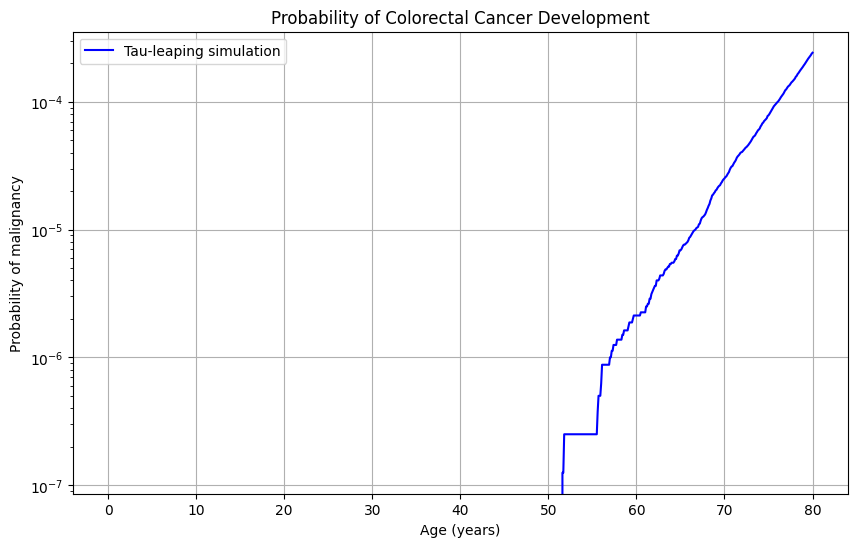

In [5]:
from tqdm import tqdm

def tau_leaping_simulation_with_progress(params: SimParams, n_runs: int = 1000, checkpoints: list = None) -> np.ndarray:
    """Run multiple tau-leaping simulations with intermediate probability output and a progress bar"""
    time_points = np.arange(0, params.t_max + params.dt, params.dt)
    malignant_counts = np.zeros(len(time_points))
    
    if checkpoints is None:
        checkpoints = []  # Default: no checkpoints
    
    # Initialize tqdm progress bar
    with tqdm(total=n_runs, desc="Simulation Progress") as pbar:
        for run in range(n_runs):
            # Update progress bar
            pbar.update(1)
            
            # Checkpoints output
            if (run + 1) in checkpoints:
                probabilities = malignant_counts / (run + 1)
                print(f"Checkpoint {run + 1}/{n_runs}:")
                print(f"Probabilities: {probabilities}")
                
            # Initialize population dictionary
            population = {State(0, 0, 0): params.N_crypts}
            had_malignant = False
            
            for t_idx, t in enumerate(time_points):
                if had_malignant:
                    malignant_counts[t_idx:] += 1
                    break
                    
                # Process each populated state
                new_events = {}
                for state, count in list(population.items()):
                    if count == 0:
                        continue
                        
                    # Check for division events (negative binomial distribution)
                    division_rate = get_division_rate(state, params)
                    if division_rate > 0:
                        p = np.exp(-division_rate * params.dt)
                        n_divisions = np.random.negative_binomial(count, p)
                        if n_divisions > 0:
                            new_events[state] = new_events.get(state, 0) + n_divisions
                    
                    # Check for transitions to neighbor states
                    for neighbor in get_neighbors(state):
                        rate = get_transition_rate(state, neighbor, params)
                        if rate > 0:
                            # Use Poisson approximation for small rates
                            if rate * params.dt < 0.01:
                                n_transitions = np.random.poisson(rate * params.dt * count)
                            else:
                                # Use binomial for larger rates
                                p = 1 - np.exp(-rate * params.dt)
                                n_transitions = np.random.binomial(count, p)
                                
                            if n_transitions > 0:
                                new_events[state] = new_events.get(state, 0) - n_transitions
                                new_events[neighbor] = new_events.get(neighbor, 0) + n_transitions
                                
                                if neighbor.is_malignant():
                                    had_malignant = True
                                    break
                
                # Update population
                for state, delta in new_events.items():
                    population[state] = population.get(state, 0) + delta
                    if population[state] < 0:  # Sanity check
                        population[state] = 0
                        
                if had_malignant:
                    malignant_counts[t_idx:] += 1
                    break
    
    return malignant_counts / n_runs

# Run the simulation with a progress bar
params = SimParams(
    dt=0.1,           # Time step size
    t_max=80.0,       # Maximum time
    N_crypts=10**8    # Number of initial crypts
)

n_runs = 8000000
checkpoints = [500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000,
               4500000, 5000000, 5500000, 6000000, 6500000, 7000000, 7500000, 8000000]

time_points = np.arange(0, params.t_max + params.dt, params.dt)
probabilities = tau_leaping_simulation_with_progress(params, n_runs=n_runs, checkpoints=checkpoints)

# Plot the results
plot_results(time_points, probabilities)




In [6]:
probabilities

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.000

In [7]:
time_points

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

In [10]:
np.savetxt("time_points.txt", time_points)